# **27. LLM Trend Note 2[프로젝트]**

## **27-1. 프로젝트: KoChatGPT 업그레이드 하기**

KoChatGPT 소스코드를 바탕으로 다양한 모델 개선 전략을 선택해 KoChatGPT를 업그레이드해 보겠습니다.<br>

아래 제시된 전략 중 하나를 선택하거나 여러 개를 조합하여
여러분만의 custom ChatGPT를 개발해보세요. 물론 더 창의적인 좋은 아이디어를 도입해볼 수도 있겠죠?<br>

복수의 전략을 선택했을 때 혼자서 실험해볼 시간이 부족하다면
팀을 이뤄 분업을 해보셔도 좋습니다!<br>

> 1.우리가 지난시간 살펴본 KoChatGPT 모델에 사용한 데이터셋은 아직 완벽히 정제되지 않았습니다.

> 2.Hunman Feedback이 반영된 데이터셋을 대체하기 위해
SFT와 RM 모델에 사용할 다양한 benchmark 데이터셋도 검토해볼 수 있습니다.

> 3.언어모델의 생성능력을 좌우하는 최선의 디코딩을 위한 하이퍼파라미터 서치가 필요합니다.

> 4.생성된 답변에 대한 주관적인 평가를 보완할 수 있는 정량적인 메트릭은 도입하지 않았었습니다.

> 5.LLM Trend Note1에서 살펴본 다양한 Instruction Tuning 및 Prompting 기법들도 적용해볼만 합니다.

> 6.무엇보다 foundation model로 사용한 KoGPT-2는 Emergent abilities를 기대하기엔 다소 작은 사이즈의 모델입니다.
더 큰 파라미터 스케일을 가진 모델을 사용해보거나,

> 7.더 효율적인 연산을 수행할 수 있는 LoRA의 적용 또는
새로운 Instruction Tuning 및 reward ranking 알고리즘을 도입해볼 수도 있습니다.

어떤 걸 해야할 지 감이 잡히지 않는 분들을 위해
몇 가지 예시를 소개해드리도록 하겠습니다.

#### **기존 데이터셋 추가 정제**

data_kochatgpt 폴더에는 세 파일이 있습니다.<br>
ㄱ. kochatgpt_1_SFT.jsonl : SFT를 위한 prompt와 completion 문장셋<br>
ㄴ. kochatgpt_1_RM.jsonl : RM 학습을 위한 prompt와 세 가지 ranking 문장셋<br>
ㄷ. kochatgpt_1_PPO.jsonl : promt 문장<br>

각 말뭉치를 EDA하여 도메인과 문체, 길이분포, 문장의 완성도 등을 분석합니다.<br>
언어모델의 문장생성능력은 말뭉치의 전처리 수준에 큰 영향을 받습니다.<br>
말뭉치의 분석결과를 토대로 데이터를 정제하여 모델을 재학습시켜봅니다.<br>
(정제후 데이터셋 크기가 줄어들지 않도록, 다양한 augmentation 기법을 활용하여 크기를 유지 내지 증량합니다.)<br>
추가 전처리 후, 기존 인퍼런스 결과와 성능을 비교해봅니다.<br>
(주관적인 평가와 BLEU, ROUGE 등을 활용한 정량적인 평가 결과를 비교 분석하여 제시합니다.)

In [1]:
# 모듈 import
import matplotlib.pyplot as plt
import json
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
from dataclasses import dataclass
from typing import Optional, Dict, Sequence
##
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora
import random
##
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer

In [2]:
# SFT 데이터셋 확인
data_path_1_SFT = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",
  'tokens': 288},
 {'prompt': '여친이랑 다툼',
  'completion': "'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.",
  'tokens': 153}]

1. `SFT 데이터셋`은 `list_dict` 형태의 데이터 구조를 가진다.
2. `list_dict` 형태의 `item`은 `prompt`와 `completion`을 각각 `Key`로 하는 `dict` 타입의 데이터이다.

In [3]:
import pandas as pd
# 데이터를 Pandas 데이터프레임으로 변환
df = pd.DataFrame(list_data_dict)

# 데이터프레임 확인
print(df)

                                          prompt  \
0                                  불고기용 고기 한우에요?   
1                                 쓰던 앱이 유료로 전환됐어   
2                                        여친이랑 다툼   
3                                        술 먹고 싶어   
4                                          잊고싶다.   
...                                          ...   
11995                  내일 개강총회인데 짝녀한테 어떻게 잘 보이지.   
11996                                    역세권이에요?   
11997  암호화폐를 분산 저장하여 운영 관리 될 수 있도록 하는 인터넷상의 방식은?   
11998                               가출해도 갈 데가 없어   
11999                                  목포극장 개업일은   

                                              completion  tokens  
0      '저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하...     193  
1      '어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 ...     288  
2      '저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하...     153  
3      '술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 ...     189  
4      '저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할

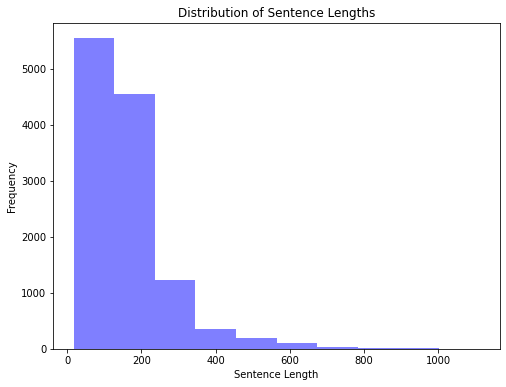

In [4]:
# 히스토그램 그리기 (tokens)
plt.figure(figsize=(8, 6))
plt.hist(df['tokens'], bins=10, alpha=0.5, color='blue')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

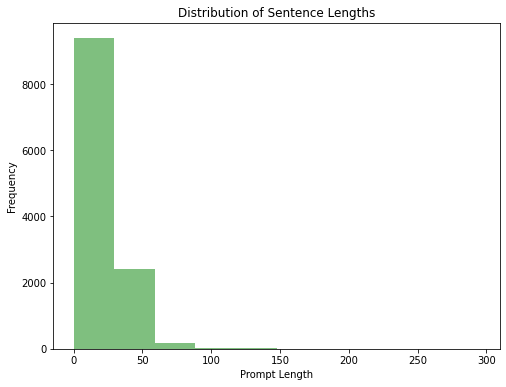

In [5]:
# 'prompt'의 문장 길이 계산
df['prompt_length'] = df['prompt'].apply(lambda x: len(x))

# 히스토그램 그리기 (prompt)
plt.figure(figsize=(8, 6))
plt.hist(df['prompt_length'], bins=10, alpha=0.5, color='green')
plt.xlabel('Prompt Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

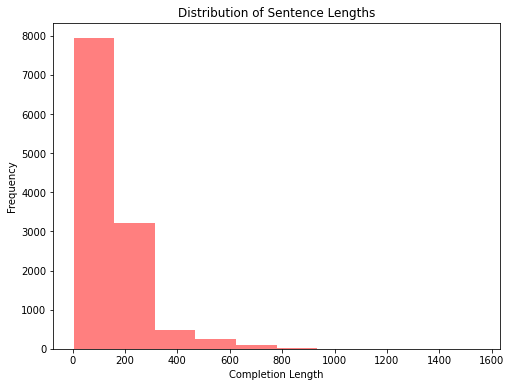

In [6]:
# 'completion'의 문장 길이 계산
df['completion_length'] = df['completion'].apply(lambda x: len(x))

# 히스토그램 그리기 (prompt)
plt.figure(figsize=(8, 6))
plt.hist(df['completion_length'], bins=10, alpha=0.5, color='red')
plt.xlabel('Completion Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

In [7]:
# 통계적 요약 정보
summary_stats = df.describe()
print(summary_stats)

             tokens  prompt_length  completion_length
count  12000.000000   12000.000000       12000.000000
mean     159.311667      22.180583         144.107250
std      109.054326      14.110028         122.843692
min       17.000000       0.000000           4.000000
25%       85.000000      13.000000          62.000000
50%      134.000000      19.000000         118.000000
75%      198.250000      28.000000         185.000000
max     1111.000000     295.000000        1553.000000


In [8]:
# SFT를 처리할 모델과 토크나이저 불러오기
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [9]:
# 모델 inferrence에서 사용할 클래스 정의
class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        data_path_1_SFT = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl'
        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]
        
        # 여기다가 전처리를 해야겠네..
        ## completion 길이별 전처리 (via MAX_LEN)
        list_data_dict = check_sentence_length(list_data_dict, MAX_LEN=250)

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [10]:
## 지도학습용 데이터 전처리 클래스 선언
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [11]:
# SFT 데이터셋 전처리 함수 생성
## completion의 길이를 체크하여 특정 길이 이상의 데이터를 없애는 로직으로 접근
def check_sentence_length(list_dict, MAX_LEN=250):
    res_list = []
    
    for item in list_dict:
        if len(item['completion']) <= MAX_LEN:
            res_list.append(item)
    
    return res_list    

In [12]:
# 훈련 데이터셋을 만들기
train_dataset = SFT_dataset(data_path_1_SFT='/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902, 13675,
          375,   378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,
         7192, 14914,   382, 37767, 13753,  8263,  7166,   739,  8352,  7659,
         9594, 25585, 13600,  8022,  9378, 11532,  9887, 11218,  9111, 16691,
        10351, 10561,  9128, 20479,  8091,  9065,  9446,  9036, 28420, 26521,
        10163, 26367,  6958,  9030,  9882, 12317, 25882,  9209, 37194, 10351,
         9036, 12168, 10529, 15989,  9719, 15434, 10552, 11188, 13362,  9036,
        15805, 11300, 11846,  9146, 16691,  9181,  7397, 15806, 13480, 11342,
        17596,  9161, 19996,  9025, 25006, 18595,  9966, 12592, 10751, 11814,
         8711,  9046, 12450,  9117,  7377, 12521,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -10

In [13]:
# 텐서를 텍스트로 디코딩하는 함수
def decode_tensor_to_text(tokenizer, tensor):
    # 텐서를 CPU로 이동하고, numpy 배열로 변환
    tensor = tensor.cpu().numpy()

    # 패딩 토큰과 -100을 제외한 토큰만 선택
    tokens = []
    for token in tensor:
        if token == tokenizer.pad_token_id or token == -100:  # 패딩 토큰 또는 -100일 경우 루프 종료
            break
        tokens.append(token)

    # 토큰을 텍스트로 디코딩
    decoded_text = tokenizer.decode(tokens, skip_special_tokens=True)
    return decoded_text

# input_ids와 labels 텐서를 디코딩하여 텍스트로 출력
input_text = decode_tensor_to_text(tokenizer, train_dataset.input_ids[0])
output_text = decode_tensor_to_text(tokenizer, train_dataset.labels[0])

print('input :', input_text)
print('output:', output_text)

input : ### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.
output: 


In [14]:
# 훈련용 Trainer 클래스 정의
training_args = TrainingArguments(
    output_dir="aiffel/KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [15]:
# SFT 훈련 진행
trainer.train()
model.save_pretrained('/aiffel/KoChatGPT/output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,2.870500
1000,2.681300


- 전처리 중 문장길이(`completion`의 길이)가 250 이하인 데이터만 학습데이터로 사용
1. 동일 `step`에서 training loss가 조금 줄었다.
    - 학습노드 기준 500 step loss : 2.984100
    - 학습노드 기준 100 step loss : 2.776800
    - 학습노드 기준 1500 step loss : 2.687200
2. 데이터가 줄어서 그런지 1500 스텝이 훈련중에 보이지 않았다.

In [16]:
# SFT 모델 검증 (문장 생성 능력 확인)
generator = pipeline('text-generation', model='/aiffel/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 실제로 불고기용 고기를 구매할 수 없습니다. 하지만 일반적으로 불고기용 고기는 다양한 종류의 요리와 함께 먹을 수 있기 때문에 취향에 따라 선택하시면 좋을 것 같습니다. 감사합니다.辛酉)辛酉辛酉申酉申酉辛酉辛

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 41대 부통령직을 수행하지 않았습니다. Captain) Control: "리처드 닉슨" 또는 "Captain Johnson" 등의 용어가 사용됩니다. Controversion)은 리처드 닉슨이 47대 부통령직을 수행할 때 사용한 용어 중

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오헤이어 국제공항은 미국 일리노이주 시카고에 위치해 있습니다. Americano Pacific Airports의 약자입니다. Americano-Pacific Administrations의 약자로 "시카고" 또는 "오헤어"를 의미합니다. Americano

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공지능 어시스턴트이므로 미세먼지와 관련된 정보를 알 수 없습니다. 하지만 인터넷 검색을 통해 미세먼지 정보를 찾아보시는 것을 추천드립니다! 감사합니다.美濃)美濃相應: "미세먼지" 입니다.美濃上應:


`BLEU SCORE`

In [17]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

def bleu_score(reference, candidate):
    # 실제 번역된 문장 (모델의 출력)
    reference = reference.split()
    
    # 모델이 생성한 번역 후보 문장
    candidate = candidate.split()
    
    # BLUE 스코어 계산
    bleu_score = sentence_bleu([reference], candidate)
    
    # 소수점 이하 4자리까지 출력
    formatted_bleu_score = format(bleu_score, '.4f')
    
    return formatted_bleu_score

`ROUGE SCORE`

In [19]:
from rouge_score import rouge_scorer

def rough_socre_n1(reference, candidate):
    
    ## ROUGE 스코어 계산; ROUGE-1 (1-gram)
    score_1 = rouge_scorer.RougeScorer(['rouge1'])
    scores_1 = score_1.score(reference, candidate)
    
    

    return scores_1

def rough_socre_n2(reference, candidate):
    ## ROUGE 스코어 계산; ROUGE-2 (2-gram)
    score_2 = rouge_scorer.RougeScorer(['rouge2'])
    scores_2 = score_2.score(reference, candidate)

    return scores_2

In [21]:
# 기존 데이터셋을 `### Instruction(명령어):`로 순회하여 얻은 답변을 기반으로 구성함
candidates_list = [
    "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.", 
    "'1953년입니다.", 
    "''", 
    "'미세먼지 농도는 어제와 비교해서 개선되었지만 아직도 나쁜 수준이며, 마스크 착용과 실외 활동 자제를 권장합니다. 정확한 미세먼지 농도를 확인하려면 해당 지역의 미세먼지 측정소에서 확인해보시기 바랍니다."
]
# 평가하고 나온 응답을 기반으로 구성함
reference_list = [
    "저는 인공지능 어시스턴트이기 때문에 실제로 불고기용 고기를 구매할 수 없습니다. 하지만 일반적으로 불고기용 고기는 다양한 종류의 요리와 함께 먹을 수 있기 때문에 취향에 따라 선택하시면 좋을 것 같습니다. 감사합니다.辛酉)辛酉辛酉申酉申酉辛酉辛", 
    "리처드 닉슨은 41대 부통령직을 수행하지 않았습니다.", 
    '시카고 오헤이어 국제공항은 미국 일리노이주 시카고에 위치해 있습니다. Americano Pacific Airports의 약자입니다. Americano-Pacific Administrations의 약자로 "시카고" 또는 "오헤어"를 의미합니다. Americano', 
    '저는 인공지능 어시스턴트이므로 미세먼지와 관련된 정보를 알 수 없습니다. 하지만 인터넷 검색을 통해 미세먼지 정보를 찾아보시는 것을 추천드립니다! 감사합니다.美濃)美濃相應: "미세먼지" 입니다.美濃上應:'
]



for i in range(len(reference_list)):
    print(f"BLEU Score: {bleu_score(reference_list[i], candidates_list[i])}")
    print("===")
    print(f"ROUGE-1 Precision: {rough_socre_n1(reference_list[i], candidates_list[i])['rouge1'].precision}")
    print(f"ROUGE-1 Recall: {rough_socre_n1(reference_list[i], candidates_list[i])['rouge1'].recall}")
    print(f"ROUGE-1 F1 Score: {rough_socre_n1(reference_list[i], candidates_list[i])['rouge1'].fmeasure}")
    print("===")
    print(f"ROUGE-2 Precision: {rough_socre_n2(reference_list[i], candidates_list[i])['rouge2'].precision}")
    print(f"ROUGE-2 Recall: {rough_socre_n2(reference_list[i], candidates_list[i])['rouge2'].recall}")
    print(f"ROUGE-2 F1 Score: {rough_socre_n2(reference_list[i], candidates_list[i])['rouge2'].fmeasure}")

BLEU Score: 0.0645
===
ROUGE-1 Precision: 0.0
ROUGE-1 Recall: 0.0
ROUGE-1 F1 Score: 0.0
===
ROUGE-2 Precision: 0.0
ROUGE-2 Recall: 0.0
ROUGE-2 F1 Score: 0.0
BLEU Score: 0.0000
===
ROUGE-1 Precision: 0.0
ROUGE-1 Recall: 0.0
ROUGE-1 F1 Score: 0.0
===
ROUGE-2 Precision: 0.0
ROUGE-2 Recall: 0.0
ROUGE-2 F1 Score: 0.0
BLEU Score: 0.0000
===
ROUGE-1 Precision: 0.0
ROUGE-1 Recall: 0.0
ROUGE-1 F1 Score: 0.0
===
ROUGE-2 Precision: 0.0
ROUGE-2 Recall: 0.0
ROUGE-2 F1 Score: 0.0
BLEU Score: 0.0000
===
ROUGE-1 Precision: 0.0
ROUGE-1 Recall: 0.0
ROUGE-1 F1 Score: 0.0
===
ROUGE-2 Precision: 0.0
ROUGE-2 Recall: 0.0
ROUGE-2 F1 Score: 0.0


/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

`ROUGE` 스코어에 사용된 문장이 이상해서 그런걸까?..

In [22]:
## CUDA 캐시 비우기
torch.cuda.empty_cache()

---

In [23]:
# RM 데이터셋 확인
data_path_2_RM = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

10220


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?',
  'completion_0': 'Allow me to answer your question. I know that you are curious about me.',
  'completion_1': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.',
  'completion_2': '라이언에게 말했다.',
  'ranking': [2, 1, 0]},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?',
  'completion_0': '개포주공아파트는 다섯 단지로 이루어져 있습니다.',
  'completion_1': '이날 목송에서 구글상위노',
  'completion_2': '개포주공아파트는 총 27개 단지로 이루어져 있습니다.',
  'ranking': [2, 0, 1]},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?',
  'completion_0': 'The diameter of the Metallic domain is bigger than the Hyperonic domain.',
  'completion_1': '이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가 그 발언을 문제삼았는지에 따라 답이 다를 수 있습니다.\\n\\n만약 김영삼 대통령이 후보 시절에 지역표심을 겨냥한 발언을 했다는 가정하에, 그 발언을 문제삼은 후보가 누구였는지를 대답하자면, 그 답은 이화선 당시 민주당 대통령 후보가 될 것입니다. 1992년 총선 때, 김영삼 대선후보는 "집값이 오른 노량진역 부근의 부동산 가격은 세월호 폭침 후 \\\'강남 도시재생\\\' 일환으로 상승했다"는 발언을 했습니다. 하지만 이화선 후보는 이 발언을 "전국적으로 경제적 발전이 이루어지지 않은 지방민의 마음을 멀리해지려는 무례한 발언"이라고 비판하며 문

In [24]:
### 데이터 EDA

In [25]:
# 데이터를 Pandas 데이터프레임으로 변환
df = pd.DataFrame(list_data_dict)

# 데이터프레임 확인
print(df)

                                                  prompt  \
0      번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독...   
1                                개포주공아파트는 몇 단지로 이루어져 있나?   
2                     김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?   
3                               페르시아로부터 기원된 아랍요리의 특징이 뭐야   
4                         중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?   
...                                                  ...   
10215                           야세르 아라파트 국제공항은 어느 나라에 있어   
10216                                          핸드폰이 잘 안돼   
10217                                          토트백은 없나요?   
10218                                               딱 좋아   
10219                 아 네 선생님 서류 확인 하겠습니다. 차 번호 어떻게 됩니까?   

                                            completion_0  \
0      Allow me to answer your question. I know that ...   
1                             개포주공아파트는 다섯 단지로 이루어져 있습니다.   
2      The diameter of the Metallic domain is bigger ...   
3      1. 다양한 스파이스와 허브 사용\n2. 쌀, 콩, 나물,

In [26]:
df.head()

,prompt,completion_0,completion_1,completion_2,ranking
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독...",Allow me to answer your question. I know that ...,번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.,라이언에게 말했다.,"[2, 1, 0]"
1,개포주공아파트는 몇 단지로 이루어져 있나?,개포주공아파트는 다섯 단지로 이루어져 있습니다.,이날 목송에서 구글상위노,개포주공아파트는 총 27개 단지로 이루어져 있습니다.,"[2, 0, 1]"
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?,The diameter of the Metallic domain is bigger ...,"이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가...",김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 ...,"[1, 2, 0]"
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야,"1. 다양한 스파이스와 허브 사용\n2. 쌀, 콩, 나물, 고기, 양파 등 다양한 ...","- 아랍요리는 소금, 산 재료, 일부 채소, 고기, 생선 또는 난류의 조합으로 만들...",위한 태야 대표 기원들 개인이라 겪고 태야\n\n\n귀식 걸 공개한 구문\n\n사띩...,"[0, 1, 2]"
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?,중화인민공화국의 기본 법률은 중국인민대표대회(국회)가 제정하고 개정합니다.,The limit of the Office of the Vice President is?,중화인민공화국의 기본 법률은 중화인민공화국의 의회가 제정 및 개정합니다.,"[0, 2, 1]"


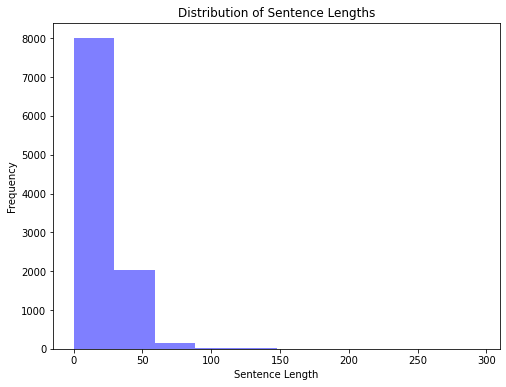

In [27]:
# 'prompt'의 문장 길이 계산
df['prompt_length'] = df['prompt'].apply(lambda x: len(x))

# 히스토그램 그리기 (prompt)
plt.figure(figsize=(8, 6))
plt.hist(df['prompt_length'], bins=10, alpha=0.5, color='blue')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

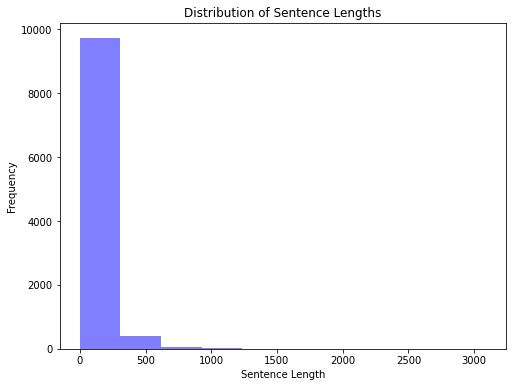

In [28]:
# 'completion_0'의 문장 길이 계산
df['completion_0_length'] = df['completion_0'].apply(lambda x: len(x))

# 히스토그램 그리기 (prompt)
plt.figure(figsize=(8, 6))
plt.hist(df['completion_0_length'], bins=10, alpha=0.5, color='blue')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

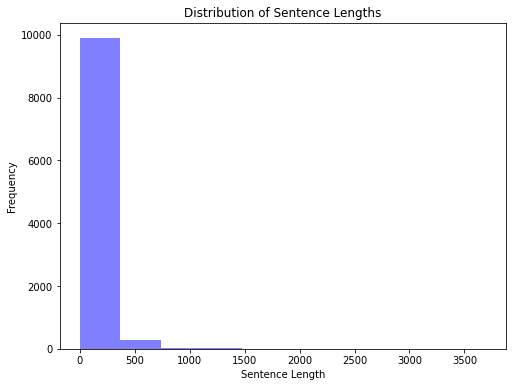

In [29]:
# 'completion_1'의 문장 길이 계산
df['completion_1_length'] = df['completion_1'].apply(lambda x: len(x))

# 히스토그램 그리기 (prompt)
plt.figure(figsize=(8, 6))
plt.hist(df['completion_1_length'], bins=10, alpha=0.5, color='blue')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

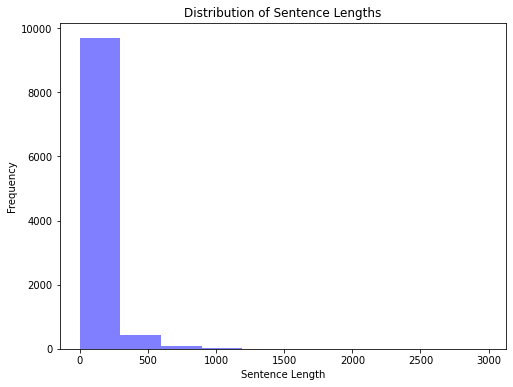

In [30]:
# 'completion_0'의 문장 길이 계산
df['completion_2_length'] = df['completion_2'].apply(lambda x: len(x))

# 히스토그램 그리기 (prompt)
plt.figure(figsize=(8, 6))
plt.hist(df['completion_2_length'], bins=10, alpha=0.5, color='blue')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

In [31]:
# 통계적 요약 정보
summary_stats = df.describe()
print(summary_stats)

       prompt_length  completion_0_length  completion_1_length  \
count   10220.000000         10220.000000         10220.000000   
mean       22.203229           117.493151           116.805675   
std        14.297097           120.476514           126.148677   
min         0.000000             0.000000             0.000000   
25%        13.000000            42.000000            42.000000   
50%        19.000000           102.000000           100.500000   
75%        28.000000           143.000000           143.000000   
max       295.000000          3088.000000          3694.000000   

       completion_2_length  
count         10220.000000  
mean            116.005479  
std             120.154507  
min               0.000000  
25%              41.000000  
50%              99.500000  
75%             142.000000  
max            2979.000000  


In [32]:
# Reward model 설계를 위한 Class 생성
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [33]:
# Reward 모델과 토크나이저 불러오기
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
## RM 훈련용 데이터셋 생성
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10220
after  data num: 30660
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 하드웨어 문제를 경험할 때, 전문가들은 필요한 수리(수리, 추가 부품 제공, 소프트웨어 업그레이드 등)을 제공해 드릴 수 있습니다. 또한, 사용자가 사용 방법 문제나 기타 문제를 경험할 때, 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다. 또한, 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다.'}


In [35]:
# Ranking 데이터셋 shuffle
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은?', 'chosen': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은 류승완의 사무실입니다.', 'rejected': '대구 영화사옥'}


In [36]:
# train, eval 데이터셋 만들기
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

1000
200


100%|██████████| 200/200 [00:00<00:00, 1240.04it/s]


In [37]:
# 훈련용 데이터셋 확인
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
흑고래의 무게는 어느 정도야
######################################################################
## chosen ##
흑고래의 평균 몸무게는 약 25~40톤 정도이지만, 최대 몸무게는 50톤 이상에 이를 수 있습니다.
######################################################################
## rejected ##
흑고래의 무게는 매우 다양하게 달라집니다. 약 200kg에서 10톤까지 달라질 수 있습니다.


In [38]:
# RM 모델 학습을 위한 arguments 설정
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [39]:
# RM 모델 훈련
trainer.fit(use_lora=0)

model.save_pretrained('aiffel/KoChatGPT/output_2_RM')

Train epoch: 100%|██████████| 1/1 [03:51<00:00, 231.15s/it]


In [40]:
# RM 인퍼런스를 체크할 수 있는 함수 생성
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

# 임의의 문장을 입력하여 적절한  reward_score를 주는지 확인
input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

input: 인공지능은 똥멍청이 입니다
reward score: 0.0


In [41]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.
reward score: 0.1


In [42]:
input_text = "인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다.
reward score: 0.3


In [43]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다.
reward score: 0.4


In [44]:
## CUDA 캐시 비우기
torch.cuda.empty_cache()

데이터 전처리를 `completion_*`의 길이 위주로 해보고 싶었는데, 데이터셋 생성의 로직이 `prompt`기반으로 판단하는 부분이 들어가 전처리를 해보지 못했다.

---

In [45]:
# PRO 데이터셋 확인
data_path_3_PPO = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?'},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?'},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?'}]

In [46]:
# Initial 모델 설정 (SFT 모델을 freezing)
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/aiffel/aiffel/KoChatGPT/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='/aiffel/aiffel/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [47]:
# 옵티마이저와 모델 준비
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [48]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [49]:
# PRO 학습에 사용할 데이터 불러와 토크나이징
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [50]:
# 임의의 문장 토큰화 결과 확인하기
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

{'input_ids': tensor([[47311, 10448, 19008,  9792, 11780, 11308, 30190, 10929, 11849, 21663,
         44389,  9574, 13799,   458, 14308, 12778, 22469, 20938, 44696,   458,
         13799,   458, 14308, 12778, 11756, 18944,   389]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [51]:
# PRO에서 사용할 데이터셋 개수 확인
len(list_prompt)

12000

In [52]:
# PRO 모델 학습을 위한 PPOTrainer() 클래스 설계
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

In [53]:
# PPO 훈련
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('/aiffel/KoChatGPT/output_3_PPO')

Episode [10/10]: 100%|██████████| 3/3 [00:17<00:00,  5.88s/it]


In [54]:
# RLHF 적용된 koGPT-2 생성능력 확인을 위한 함수 생성
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output
# 명령어, 답변 테스트
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'불고기는 다른 고기보다 부드럽고 맛이 좋아, 불고기와 함께 먹으면 더 잘 어울린다는 평가입니다. 하지만, 이는 개인의 건강을 최우선으로 생각하는 사람들의 의견을 존중하면서, 과학적으로 판단해야 합니다. 이는 올바른 정보이며, 불고기, 불고기, 불고기, 그리고 불고기의 종류에 따라 다르기 때문에 전문가의 추천을 받는 것이 좋습니다. Lengaughter Matching Chicken health usbying House. long up, juice your capability to restaurate requestructions. Lengaughter Matching Chicken health use capability you. Lang-wer give travels to child. Long is what emotions your engine and surry each belic, producing capability opportunity in your statement. Leng

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'1979년입니다. 톰슨과 그의 아내는 앤서니 컬럼즈와 크리스 앤드리슨에 의해 미국 대통령이 되었습니다. 따라서 이 질문에 대한 명확한 답을 얻기 위해서는 추가적인 정보가 필요합니다. <\n\nChuntry>는 닉슨 전 대통령이 1980년 12월 19일에 열린 공화당 대선 경선에서 38대 부통령 자리를 맡으면서 발표한 일입니다. <brown>은 미국의 부통령 후보들 중 가장 유력자로 알려진 존 매케인의 회고록입니다. <brown>은 닉슨 전 대통령이 1980년대 초반부터 2000년대 초반까지 부통령을 맡으면서, 그의 재임 기간에 관한 내용을 담고 있습니다. <brown>은 닉슨 전 대통령이 재임 중 일으킨 사건들의 결과 중 하나로, 부통령으로 선출되었을 때, 그녀의

해당 모델도 테스트만 해본게 아쉽다..

---

#### **새로운 데이터셋 추가**

KoChatGPT는 human feedback이 반영된 데이터를 직접 사용하는 대신<br>
ChatGPT API를 사용하는 대안을 선택했습니다.<br>
LLM Trend Note1 에서 살펴보았듯이<br>
Anthropic의 RLHF는 StackExchange 같은 온라인 상의 댓글정보를 활용하여<br>
ranking dataset을 구축해 구현되었습니다.<br>
우리도 비슷한 로직을 적용해볼 수 있습니다.<br>

하나의 prompt에 대한 다양한 수준의 품질로 댓글이 달린 한국어로 된 웹사이트를 찾아봅시다.<br>
웹크롤링 기법을 사용해 reward 점수를 차등적으로 적용해볼 수 있는<br>
instruction dataset과 ranking dataset을 구축해봅니다.<br>

[KorQuAD 2.0](https://korquad.github.io/) 같은 한국어 이해 benchmark를 활용해 고품질의 데이터셋을 확보하고,<br>
KoGPT-2를 사용해 빠르게 저품질 데이터셋을 페어링해볼 수도 있습니다.<br>
다양한 데이터 증량전략을 구사하여 기존 데이터셋에 새로 구축한 데이터셋을 추가해<br>
모델을 재학습시키고 추론 결과를 비교하 분석하여 제시해보세요.

#### **foundation model 교체**

현재 제공되는 LMS GPU 사양으로는 수십 billion 단위 이상의 LLM을 튜닝하기 어렵습니다.<br>
그러나 허깅페이스에서 제공하는 큰 규모의 모델을 적은 컴퓨팅 자원으로도 사용할 수 있게 해주는<br>
경량화, 최적화 라이브러리를 사용하면<br>
속도는 느리지만 우리의 LMS에서도 학습 및 추론이 가능해질 수 있습니다.<br>
(힌트 : LLM Trend Note1 노드의 마지막 스텝을 참고해보세요)<br>

허깅페이스에서 제공되는 1.2B 사이즈의 한국어 GPT pretrain model로 [skt/ko-gpt-trinity-1.2B-v0.5](https://huggingface.co/skt/ko-gpt-trinity-1.2B-v0.5) 가 있습니다.<br>
해당 모델로 foundation model을 교체해보세요.<br>
(단 OOM 문제를 해소하기 위해 허깅페이스에서 제공하는<br>
다양한 training argument들을 조합하여 최상의 하이퍼파라미터를 찾아내야 합니다.)<br>
데이터셋을 아예 바꿔 모델 선택의 폭을 늘려보는 것도 좋은 선택지입니다.<br>

foundation model 교체에 성공했다면, generator 함수를 수정하여 모델 인퍼런스 결과를 제시해보세요.

In [55]:
# 모델 선언
model_name = 'EleutherAI/LLaMA'
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(
    model_name, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.9/site-packages/huggingface_hub/utils/_errors.py:259 in                   │
│ hf_raise_for_status                                                                              │
│                                                                                                  │
│   256 │   </Tip>                                                                                 │
│   257 │   """                                                                                    │
│   258 │   try:                                                                                   │
│ ❱ 259 │   │   response.raise_for_status()                                                        │
│   260 │   except HTTPError as e:                                                                 │
│   261 │   │   error_code = response.headers.get("X-Error-Code")                                  │
│   262                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/requests/models.py:953 in raise_for_status                │
│                                                                                                  │
│   950 │   │   │   http_error_msg = u'%s Server Error: %s for url: %s' % (self.status_code, rea   │
│   951 │   │                                                                                      │
│   952 │   │   if http_error_msg:                                                                 │
│ ❱ 953 │   │   │   raise HTTPError(http_error_msg, response=self)                                 │
│   954 │                                                                                          │
│   955 │   def close(self):                                                                       │
│   956 │   │   """Releases the connection back to the pool. Once this method has been             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
HTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/EleutherAI/LLaMA/resolve/main/config.json

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.9/site-packages/transformers/utils/hub.py:409 in cached_file              │
│                                                                                                  │
│    406 │   user_agent = http_user_agent(user_agent)                                              │
│    407 │   try:                                                                                  │
│    408 │   │   # Load from URL or cache if already cached                                        │
│ ❱  409 │   │   resolved_file = hf_hub_download(                                                  │
│    410 │   │   │   path_or_repo_id,                                                              │
│    411 │   │   │   filename,                                                                     │
│    412 │   │   │   subfolder=None if len(subfolder) == 0 else subfolder,                         │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/huggingface_hub/utils/_validators.py:118 in _inner_fn     │
│                                                                                                  │
│   115 │   │   if check_use_auth_token:                                                           │
│   116 │   │   │   kwargs = smoothly_deprecate_use_auth_token(fn_name=fn.__name__, has_token=ha   │
│   117 │   │                                                               

##### **참고**

LLM Trend Note2 노드에서 살펴본 KoChatGPT 소스코드는<br>
빠르게 baseline모델을 설계해 실습해보기 위해 오리지널 코드를 일부 수정한 버전입니다.<br>
프로젝트 진행을 위해 모델을 커스터마이징할 때, 필요시 "colossalai_ChatGPT_230319" 폴더 내의 원본 스크립트들을 참고하세요.

## **27-2. 프로젝트 제출**

##### **루브릭**
아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|상세기준|
|--|--|
|1. 기존 데이터셋을 추가 정제하고, generation 성능을 끌어올리기 위한 기법들을 실험해 모델 perfomance를 향상시켜보았는가?	|기존 데이터셋의 문제점을 분석하고 전처리 전략을 수립해 추가 정제를 진행했다. Beam search, Top-k(p) sampling 등 최선의 디코딩 전략을 수립해 향상된 모델 추론 결과를 제시했다. BLEU, ROUGE 등 생성된 텍스트를 평가하기 위한 메트릭을 적용한 정량적인 평가 결과와 주관적인 평가를 비교분석하였다.|
|2. 새로운 데이터를 수집해 전처리를 수행하여 모델을 재학습시켜보았는가?|모두의 말뭉치, AI hub 등에 공개된 데이터를 사용해 추가 데이터셋을 구축하기 위한 기준과 근거를 수립했다. ChatGPT API나 다양한 한국어 benchmark 데이터셋을 활용해 Human Feedback 을 대체할 수 있는 아이디어를 구현했다. 위를 바탕으로 SFT, RM, PPO 세 단계에 필요한 각 데이터셋을 적절히 구축하여, 모델 추론 결과와 수립한 가설을 비교해보았다.|
|3. 학습 전략 또는 foundation model을 변경해 모델을 재학습시켜보았는가?|더 적절한 Instruction Tuning 기법을 적용해 SFT를 해보거나, Reward Model의 ranking algorithm을 개선해보았다. KoGPT-2가 아닌 다른 모델을 initial model로 사용하여 모델 학습을 성공시켰다. 허깅페이스의 accelerate, bitsandbytes 라이브러리 등을 사용하여 더 큰 스케일의 모델로 ChatGPT를 re-building해 모델 성능을 향상시켰다.|